# Example 5:  Structured environments and TCL

This example provides the necessary code to reproduce the calculations from example 4 in [2](https://arxiv.org/abs/2506.22346), where the Hamiltonian is given by

\begin{align}
	H = \omega_{0} \sigma_{+} \sigma_{-}                     
	+ \sum_{k} \omega_{k} b_{k}^{\dagger}b_{k}             
	+ \sigma_{+} \otimes \sum_{k} g_{k} b_{k} +H.C .
\end{align}
For TCL and the RWA exact solution and 
\begin{align}
	H = \omega_{0} \sigma_{+} \sigma_{-}                     
	+ \sum_{k} \omega_{k} b_{k}^{\dagger}b_{k}             
	+ \sigma_{x} \sum_{k} g_{k} (b_{k} +b_{k}^{\dagger})
\end{align}
For the methods supported by this package and QutiP. The main pourpose of this 
example is to show the usage of Non-Markovian master equations with structured 
environments as well as to show how the exponent approximation can be used with 
TCL and Volterra equations. We first begin by importing the necessary packages

In [37]:
import numpy as np
from scipy.integrate import solve_ivp
from qutip import BosonicEnvironment
import matplotlib.pyplot as plt
from qutip import spre,spost,sprepost,sigmap,sigmam,Qobj
from spectral_density_data import spectral_density
from nmm import cumulant,redfield
import time
from qutip import heom

The next block of code generates and solves the system of ODEs that replaces the 
Volterra equation, it also provides the generator of TCL as explained in [2]()

In [6]:


def solve_c1_system(cks, vks, c1_0, t_span=(0, 50), t_eval=None):
    """
    Solves the system:
        dot{c1} = -sum yk
        dot{yk} = -vk * yk + ck * c1
    Parameters:
        cks : list or array of c_k coefficients
        vks : list or array of v_k (decay rates)
        c1_0 : float, initial condition for c1(t)
        t_span : tuple, (t0, tf)
        t_eval : array, optional time grid for evaluation
    Returns:
        t, c1, ys : time array, c1(t) array, y_k(t) array
    """
    cks = np.array(cks, dtype=complex)
    vks = np.array(vks, dtype=complex)
    N = len(cks)

    def system(t, u):
        c1 = u[0]
        ys = u[1:]
        
        # Calculate the time derivatives of c1 and yk
        dc1_dt = -np.sum(ys)
        dys_dt = -(vks) * ys + cks * c1
        
        # Ensure ys don't go below 0 (clipping to prevent negative values)        
        return np.concatenate([[dc1_dt], dys_dt])

    # Initial conditions
    u0 = np.concatenate([[c1_0],  np.zeros_like(cks)])

    # Time grid
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 1000)

    # Solve ODE system using 'RK45' method for better stability
    sol = solve_ivp(system, t_span, u0, t_eval=t_eval, method='RK45', vectorized=False)

    t = sol.t
    c1 = sol.y[0]
    ys = sol.y[1:]
    return t, c1, ys
def g4(ck,vk,w0,t):
    # if this does not work -iwo to vk
    diff=[]
    sam=[]
    for i in range(len(ck)):
        for j in range(len(ck)):
            if i!=j:
                a=1j*w0-vk[i]
                b=vk[j]-1j*w0
                mul=(ck[i]*ck[j])/(a*b)
                uno=np.exp(-t*b)/(vk[i]-vk[j])
                dos=np.exp(-t*(vk[i]+vk[j]-2*1j*w0))/b
                tres=-1/a
                cuatro=(t - 1/a - 1/b + 1/(vk[j]-vk[i]))*np.exp(t*a)
                diff.append(mul*(uno+dos+tres+cuatro))
            else:
                a=vk[i]-1j*w0
                mul=(ck[i]**2)/(a**3) 
                uno=1-np.exp(-2*t*a)-2*t*np.exp(-t*a)*a
                sam.append(mul*uno)
    different= sum(diff)
    same=sum(sam)
    return 2*(different+same)
def g2(ck,vk,w0,t):
    exp=[]
    # if this does not work -iwo to vk
    for i in range(len(ck)):
        mul=ck[i]/(vk[i]-1j*w0)
        fd=(1-np.exp(-(vk[i]-1j*w0)*t))
        exp.append(mul*fd)
    return 2*sum(exp)
def gamma4(ck,vk,w0,t):
    return g4(ck,vk,w0,t) + g2(ck,vk,w0,t)
def master_eq_gen(func,ck,vk,w0,t):
    gamma= func(ck,vk,w0,t).real
    s=-1j*func(ck,vk,w0,t).imag/2
    A=sigmap()*sigmam()
    comm=(spre(A) - spost(A))
    relax= spre(sigmam())*spost(sigmap()) 
    relax2 = - (spre(A) + spost(A))/2
    return s*comm + gamma*(relax+relax2)

We now construct the Hamiltonian, and prepare or bosonic environment with the 
structured spectral density 

In [ ]:
w0=12.1 # the other plot in the article is 12.1*0.992
H = w0 * sigmap() * sigmam()
Q = sigmap() + sigmam() # Simulations other than TCL and exact are done without the RWA
w=np.linspace(0,50,10_000)
J=spectral_density(w)
wp=np.linspace(0,19,10_000)
Jp=spectral_density(wp)
env=BosonicEnvironment.from_spectral_density(J,wlist=w,T=0)
env2=BosonicEnvironment.from_correlation_function(lambda t:env.correlation_function(t)*np.exp(1j*w0*t),T=0)
rho0=Qobj([[1,0],[0,0]])


We approximate it using exponents. In the previous section we considered two different baths, the original one and another where the correlation function is 
nodified by a phase, one will be passed to the volterra solver, while the other 
is used for the rest

In [19]:
t=np.linspace(0,135,1_000)
bath,_=env.approximate("espira-I",t,Nr=50)
bath2,_=env2.approximate("espira-I",t,Nr=50)

We now contrast our original and effective environments 

<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_20867/301134038.py:18: SyntaxWarning: invalid escape sequence '\o'
  tick_labels = ['$\omega_{0}$']


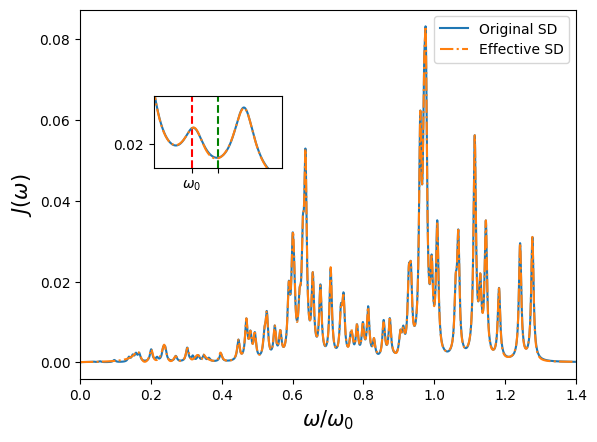

In [20]:
fig, ax = plt.subplots()
ax.plot(wp/w0,Jp,label='Original SD')
ax.plot(wp/w0,bath.spectral_density(wp),'-.',label='Effective SD')
ax.set_xlabel(r"$\omega/\omega_{0}$", fontsize=15)
ax.set_ylabel(r"$J(\omega)$", fontsize=15)
ax.set_xlim(0,1.4)

# Add inset
inset = fig.add_axes([0.24, 0.55, 0.2, 0.15])  # [left, bottom, width, height]
inset.plot(wp/w0,Jp)
inset.plot(wp/w0,bath.spectral_density(wp),'-.')
inset.axvline(x=.992,linestyle='--',color='red',zorder=1)
inset.axvline(x=1,linestyle='--',color='green',zorder=1)

inset.set_xlim(0.98, 1.02)  
inset.set_ylim(0.01, 0.04)  
tick_locations = [0.992,1]
tick_labels = ['$\omega_{0}$']
inset.xaxis.set_major_locator(plt.FixedLocator(tick_locations))
inset.xaxis.set_major_formatter(plt.FixedFormatter(tick_labels))
tick_locations = [0.02]
tick_labels = ['0.02']
inset.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
inset.yaxis.set_major_formatter(plt.FixedFormatter(tick_labels))
ax.legend()


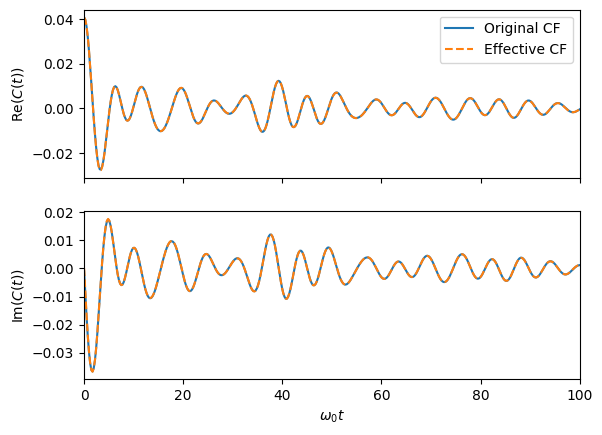

In [41]:
tp=np.linspace(0,100,5000)
fig, (ax_real, ax_imag) = plt.subplots(2, 1, sharex=True) # 2 rows, 1 column, share x-axis
ax_real.plot(tp*w0,bath.correlation_function(tp).real,label='Original CF')
ax_real.plot(tp*w0,env.correlation_function(tp).real,'--',label='Effective CF')
ax_imag.plot(tp*w0,bath.correlation_function(tp).imag)
ax_imag.plot(tp*w0,env.correlation_function(tp).imag,'--')
ax_imag.set_xlim(-0.1,100)
ax_imag.set_ylabel(r"$\mathrm{Im}(C(t))$")
ax_real.set_ylabel(r"$\mathrm{Re}(C(t))$")
ax_imag.set_xlabel(r"$\omega_{0} t$")

ax_real.legend()


Finally, we perform our simulations

In [24]:
c1_0=1
start=time.time()
cks=np.array([i.coefficient for i in bath2.exponents])
vks=np.array([i.exponent for i in bath2.exponents])
tmax=20/np.max(J)
t1, c1, ys = solve_c1_system(cks, vks, c1_0,t_span=(0,tmax))
end=time.time()

In [36]:
rho0=Qobj([[1,0],[0,0]])
start2=time.time()
cum=cumulant.csolve(Hsys=H,Qs=[Q],baths=[bath],t=t1,matsubara=True,cython=False,ls=True)
cum_re=cum.evolution(rho0)
end2=time.time()
start3=time.time()
red=redfield.redfield(Hsys=H,Qs=[Q],baths=[bath],t=t1,matsubara=True,ls=True)
red_re=red.evolution(rho0)
end3=time.time()


Calculating time dependent generators: 100%|█████████████████████████████████████████████████| 4/4 [00:00<00:00, 125.26it/s]
Computing Exponential of Generators . . . .: 1000it [00:00, 3626.00it/s]


Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.09030461311340332
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.002148866653442383
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:0.0584568977355957


In [34]:
def f(t, y):
    return master_eq_gen(gamma4,cks2,vks2,w0,t).full()@y
print("Started Solving the differential equation")
tcl4 = solve_ivp(f, [0, t1[-1]],
                    y0,
                    t_eval=t1, method="BDF")

Started Solving the differential equation


In [38]:
heom_solution = heom.heomsolve(H, (bath,Q), 2, rho0, t1)

# --- Transform to interaction picture ---

Us = [(-1j * H * t).expm() for t in t1]
heom_states = [U * state * U.dag() for (U, state) in zip(Us, heom_solution.states)]

10.0%. Run time:   3.17s. Est. time left: 00:00:00:28
20.0%. Run time:   6.78s. Est. time left: 00:00:00:27
30.0%. Run time:   9.60s. Est. time left: 00:00:00:22
40.0%. Run time:  12.34s. Est. time left: 00:00:00:18
50.1%. Run time:  15.01s. Est. time left: 00:00:00:14
60.1%. Run time:  17.67s. Est. time left: 00:00:00:11
70.1%. Run time:  20.31s. Est. time left: 00:00:00:08
80.1%. Run time:  22.90s. Est. time left: 00:00:00:05
90.1%. Run time:  25.51s. Est. time left: 00:00:00:02
100.0%. Run time:  28.21s. Est. time left: 00:00:00:00
Total run time:  28.22s


Now, we observe the result

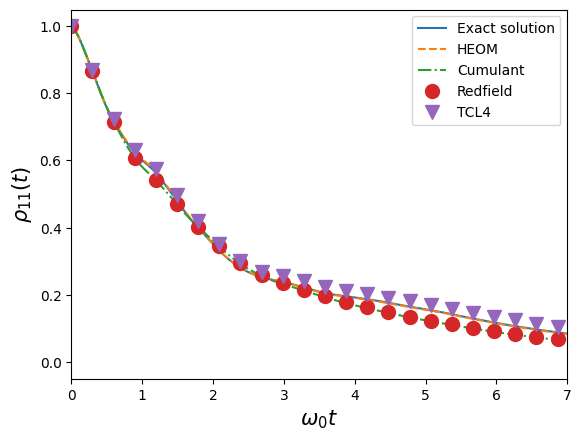

In [ ]:
fig, ax = plt.subplots()
ax.plot(t1/w0, abs(c1)**2 , label=rf'Exact solution')
ax.plot(t1/w0, np.array([i[0,0] for i in heom_states]), linestyle="--",label='HEOM')
ax.plot(t1/w0, np.array([i[0,0] for i in cum_re]), linestyle="-.",label='Cumulant')
ax.plot(t1/w0, tcl4.y[0],linestyle="None",marker="v",markevery=15,markersize=10,label='TCL4')
ax.legend()
ax.set_xlabel(r"$\omega_{0}t$", fontsize=15)
ax.set_ylabel(r"$\rho_{11}(t)$", fontsize=15)
plt.xlim(0,7)
plt.show()

We can see the approximate solutions are really close to the exact one.